In [1]:
import os
import glob
from scipy.stats import mode
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedShuffleSplit


In [2]:
# Hyperparameters
SEQ_LEN = 90
STEP_SIZE = 45
NUM_KEYPOINTS = 17
INPUT_DIM = 5
HIDDEN_DIM = 64
NUM_CLASSES = 9
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
PATIENCE = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# COCO keypoint graph edges
COCO_EDGES = [(0, 1), (0, 2),         # Nose to eyes
              (1, 3), (2, 4),         # Eyes to ears
              (0, 5), (0, 6),         # Nose to shoulders
              (5, 7), (7, 9),         # Left arm
              (6, 8), (8, 10),        # Right arm
              (5, 11), (6, 12),       # Shoulders to hips
              (11, 12),               # Hip connection
              (11, 13), (13, 15),     # Left leg
              (12, 14), (14, 16)      # Right leg
]

adj = torch.eye(NUM_KEYPOINTS)
for i, j in COCO_EDGES:
    adj[i, j] = 1
    adj[j, i] = 1

In [3]:
# Label mapping 
LABELS = ['Attacking',
 'Biting',
 'Eating snacks',
 'Head banging',
 'Sitting quietly',
 'Throwing things',
 'Using phone',
 'Walking',
 'label_nan']
label_map = {label: idx for idx, label in enumerate(LABELS)}
label_map

{'Attacking': 0,
 'Biting': 1,
 'Eating snacks': 2,
 'Head banging': 3,
 'Sitting quietly': 4,
 'Throwing things': 5,
 'Using phone': 6,
 'Walking': 7,
 'label_nan': 8}

In [4]:
def calculate_joint_angle(p1, p2, p3):
    """Calculates the angle (in degrees) at vertex p2."""
    vec1 = p1 - p2
    vec2 = p3 - p2
    angle = np.degrees(np.arctan2(vec2[:, 1], vec2[:, 0]) - np.arctan2(vec1[:, 1], vec1[:, 0]))
    angle = np.abs(angle % 360)
    # Ensure the angle is the smaller one (<= 180)
    mask = angle > 180
    angle[mask] = 360 - angle[mask]
    return angle

In [5]:
def extract_features(df):

    coord_cols = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]
    parts = sorted(set(c.rsplit('_', 1)[0] for c in coord_cols))

    # GET VELOCITY AND ACCELERATION
    vel = {}
    acc = {}
    for part in parts:
        x = df[f"{part}_x"]
        y = df[f"{part}_y"]
        dx = x.diff()
        dy = y.diff()
        speed = np.sqrt(dx**2 + dy**2)
        vel[f"{part}_speed"] = speed

        ddx = dx.diff()
        ddy = dy.diff()
        accel = np.sqrt(ddx**2 + ddy**2)
        acc[f"{part}_accel"] = accel
        
    vel_df = pd.DataFrame(vel)
    acc_df = pd.DataFrame(acc)
    vel_df = vel_df.fillna(0)
    acc_df = acc_df.fillna(0)

    # GET DISTANCE 
    dist = {}
    for i in range(len(parts)):
        for j in range(i + 1, len(parts)):
            p1, p2 = parts[i], parts[j]
            dx = df[f"{p1}_x"] - df[f"{p2}_x"]
            dy = df[f"{p1}_y"] - df[f"{p2}_y"]
            dist[f"dist_{p1}_{p2}"] = np.sqrt(dx**2 + dy**2)
    
    dist_df = pd.DataFrame(dist)

 
    dist_useful = ['dist_left_ankle_left_hip', 'dist_left_ear_left_shoulder', 'dist_left_elbow_left_knee', 'dist_left_eye_left_wrist',
                'dist_left_hip_left_wrist', 'dist_left_knee_left_wrist', 'dist_left_shoulder_left_wrist', 'dist_left_wrist_nose',
                'dist_nose_right_wrist', 'dist_right_ankle_right_hip', 'dist_right_ear_right_shoulder', 'dist_right_elbow_right_knee',
                'dist_right_eye_right_wrist', 'dist_right_hip_right_wrist', 'dist_right_knee_right_wrist', 
                'dist_right_shoulder_right_wrist', 'dist_right_ankle_right_wrist']
    dist_df = dist_df[dist_useful]

    # GET ANGLES
    # Basic Joint Angles
    # angle_definitions = {
    #     'left_ankle': [],
    #   'left_ear':['nose', 'left_ear', 'left_shoulder'],
    #     'left_elbow': ['left_shoulder', 'left_elbow', 'left_wrist'],
    #     'left_eye': ['left_ear', 'left_eye', 'left_wrist'],
    #       'left_hip': ['left_shoulder', 'left_hip', 'left_knee'],
    #       'left_knee': ['left_hip', 'left_knee', 'left_ankle'],
    #     'left_shoulder': ['left_elbow', 'left_shoulder', 'left_hip'],
    #       'left_wrist': [],
    #       'nose': ['left_shoulder',  'nose', 'right_shoulder'],
    #       'right_ankle': [],
    #       'right_ear': ['nose', 'right_ear', 'right_shoulder'],
    #     'right_elbow': ['right_shoulder', 'right_elbow', 'right_wrist'],
    #     'right_eye': ['right_ear', 'right_eye', 'right_wrist'],
    #     'right_hip': ['right_shoulder', 'right_hip', 'right_knee'],   
    #     'right_knee': ['right_hip', 'right_knee', 'right_ankle'],
    #     'right_shoulder': ['right_elbow', 'right_shoulder', 'right_hip'],
    #     'right_wrist': []
    # }
    # angle_df = {}
    # for name, joints in angle_definitions.items():
    #     if len(joints) == 3:
    #         p1 = df[[f'{joints[0]}_x', f'{joints[0]}_y']].values
    #         p2 = df[[f'{joints[1]}_x', f'{joints[1]}_y']].values
    #         p3 = df[[f'{joints[2]}_x', f'{joints[2]}_y']].values
    #         angle_df[f'{name}_angle'] = calculate_joint_angle(p1, p2, p3)
    #     else:
    #         angle_df[f'{name}_angle'] = 0.0

    # angle_df = pd.DataFrame(angle_df)

    extracted_features = pd.concat([vel_df, acc_df, dist_df], axis=1)
  
    return extracted_features
    

In [6]:
# Dataset class
class KeypointDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels 

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# GCN layer
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        support = self.linear(x)
        out = torch.matmul(adj, support)
        return out
    
class GCN_LSTM_Model(nn.Module):
    def __init__(self):
        super(GCN_LSTM_Model, self).__init__()
        self.gcn1 = GCNLayer(INPUT_DIM, 32)
        self.gcn2 = GCNLayer(32, 64)
        self.gcn3 = GCNLayer(64, 128)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.lstm1 = nn.LSTM(input_size=128 * NUM_KEYPOINTS, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)

        self.ln1 = nn.LayerNorm(128)
        self.ln2 = nn.LayerNorm(64)
        self.ln3 = nn.LayerNorm(32)

        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, NUM_CLASSES)

        self.final_dropout = nn.Dropout(0.4)

    def forward(self, x):
        B, T, N, D = x.shape
        x = x.view(B * T, N, D)
        
        x = self.relu(self.gcn1(x, adj.to(x.device)))
        x = self.dropout(x)

        x = self.relu(self.gcn2(x, adj.to(x.device)))
        x = self.dropout(x)

        x = self.relu(self.gcn3(x, adj.to(x.device)))
        x = self.dropout(x)        

        x = x.view(B, T, -1)     #flatten gcn output for lstm

        x, _ = self.lstm1(x)
        x = self.ln1(x)

        x, _ = self.lstm2(x)
        x = self.ln2(x)

        x, _ = self.lstm3(x)
        x = self.ln3(x)

        x = x[:, -1, :]     #use last time step
        
        x = self.final_dropout(self.relu(self.fc1(x)))
        x = self.final_dropout(self.relu(self.fc2(x)))
        out = self.fc3(x)

        return out


In [7]:

# # Prepare sequences from a single CSV
def prepare_sequences(df):
    df = df[df['label'].isin(LABELS)]
    keypoint_df = df.drop(columns=['frame_id', 'label'])
    kp_data = keypoint_df.values
    labels = df['label'].map(label_map).values

    sequences, seq_labels = [], []
    for i in range(0, len(df) - SEQ_LEN + 1, STEP_SIZE):
        seq = kp_data[i:i+SEQ_LEN]
        label_window = labels[i : i + SEQ_LEN]
        label = int(mode(label_window, keepdims=True)[0][0])
        seq = seq.reshape((SEQ_LEN, NUM_KEYPOINTS, INPUT_DIM))
        sequences.append(seq)
        seq_labels.append(label)

    return np.array(sequences), np.array(seq_labels)



In [8]:

# Load all subjects
def load_all_subjects(data_dir):
    files = glob.glob(os.path.join(data_dir, "*.csv"))
    all_dfs = []
    for file in files:
        df = pd.read_csv(file)

        #  PREPROCESSING
        df['label'] = df['label'].fillna('label_nan')
        df['label'] = df['label'].replace('Throwing', 'Throwing things')

        # remove negatives
        df = df[(df.select_dtypes(include=[np.number]) >= 0).all(axis=1)]

        # remove anomalies using z-score
        coords_columns = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]
        z_scores = ((df[coords_columns] - df[coords_columns].mean()) / df[coords_columns].std()).abs()
        outliers = (z_scores > 4).any(axis=1)   
        outlier_rows = df[outliers]
        outlier_indices = outlier_rows.index.tolist()   # Get rows index where outliers is True
        df_no_anomalies = df.drop(index=outlier_indices)
        df_no_anomalies.reset_index(inplace=True, drop=True) 

        # extract features and remove anomalies
        extracted_features = extract_features(df_no_anomalies)

        z_features = ((extracted_features.select_dtypes(include=[np.number]) -
               extracted_features.select_dtypes(include=[np.number]).mean()) /
               extracted_features.select_dtypes(include=[np.number]).std()).abs()
        anomalies = (z_features > 4).any(axis=1)
        anomalies_rows = extracted_features[anomalies]
        anomalies_index = anomalies_rows.index.tolist()
        extracted_features_no_anomalies = extracted_features.drop(index = anomalies_index)
        
        df_no_anomalies = df_no_anomalies.drop(index = anomalies_index)

        # reset index
        df_no_anomalies.reset_index(inplace=True, drop=True)
        extracted_features_no_anomalies.reset_index(inplace=True, drop=True)

        # merge all features
        final_df = pd.concat([df_no_anomalies.drop(columns=['label']), extracted_features_no_anomalies, df_no_anomalies[['label']]], axis=1)


        # scaling
        feature_columns = final_df.columns.difference(['frame_id', 'label'])
        ss = StandardScaler()
        sub_scaled = final_df.copy()
        sub_scaled[feature_columns] = ss.fit_transform(final_df[feature_columns])   
        
        order = [0,1,2,43,60,77,
                3,4,38,55,72,
                5,6,47,64,81,
                7,8,36,53,70,
                9,10,45,62,79,
                11,12,41,58,75,
                13,14,50,67,84,
                15,16,37,54,71,
                17,18,46,63,80,
                19,20,42,59,76,
                21,22,51,68,85,
                23,24,39,56,73,
                25,26,48,65,82,
                27,28,40,57,74,
                29,30,49,66,83,
                31,32,35,52,69,
                33,34,44,61,78,86]
        # order = [0,1,2,43,60,77,94,
        # 3,4,38,55,72,89,
        # 5,6,47,64,81,98,
        # 7,8,36,53,70,87,
        # 9,10,45,62,79,96,
        # 11,12,41,58,75,92,
        # 13,14,50,67,84,101,
        # 15,16,37,54,71,88,
        # 17,18,46,63,80,97,
        # 19,20,42,59,76,93,
        # 21,22,51,68,85,102,
        # 23,24,39,56,73,90,
        # 25,26,48,65,82,99,
        # 27,28,40,57,74,91,
        # 29,30,49,66,83,100,
        # 31,32,35,52,69,86,
        # 33,34,44,61,78,95,103]
        sub_scaled_ordered = sub_scaled.iloc[:, order]

        # all_dfs.append(sub_scaled_ordered)
        sequences, labels = prepare_sequences(sub_scaled_ordered)
        if len(sequences) > 0:
            all_dfs.append((sequences, labels, os.path.basename(file)))
        # final_df = pd.concat(all_dfs, ignore_index=True)
    return all_dfs

In [9]:
#Main
dir = r'D:\pr_env\py_env\Scripts\keypointlabel'
subjects_data = load_all_subjects(dir)  
# subjects_data

Epoch 1: Train Loss=2.1060, Train Acc=0.1783
 Val Loss=1.9712, Val Acc=0.4097
Epoch 2: Train Loss=1.8920, Train Acc=0.3010
 Val Loss=1.7232, Val Acc=0.4973
Epoch 3: Train Loss=1.6909, Train Acc=0.3709
 Val Loss=1.5323, Val Acc=0.5259
Epoch 4: Train Loss=1.5261, Train Acc=0.4240
 Val Loss=1.3289, Val Acc=0.5921
Epoch 5: Train Loss=1.4077, Train Acc=0.4658
 Val Loss=1.2326, Val Acc=0.5903
Epoch 6: Train Loss=1.3200, Train Acc=0.4948
 Val Loss=1.1015, Val Acc=0.6225
Epoch 7: Train Loss=1.2026, Train Acc=0.5422
 Val Loss=1.0983, Val Acc=0.5957
Epoch 8: Train Loss=1.1531, Train Acc=0.5583
 Val Loss=1.0470, Val Acc=0.6208
Epoch 9: Train Loss=1.0851, Train Acc=0.5947
 Val Loss=0.9238, Val Acc=0.6744
Epoch 10: Train Loss=1.0036, Train Acc=0.6122
 Val Loss=0.8216, Val Acc=0.7209
Epoch 11: Train Loss=0.9541, Train Acc=0.6285
 Val Loss=0.9110, Val Acc=0.7102
Epoch 12: Train Loss=0.9208, Train Acc=0.6427
 Val Loss=0.7496, Val Acc=0.7549
Epoch 13: Train Loss=0.8629, Train Acc=0.6578
 Val Loss=0.822

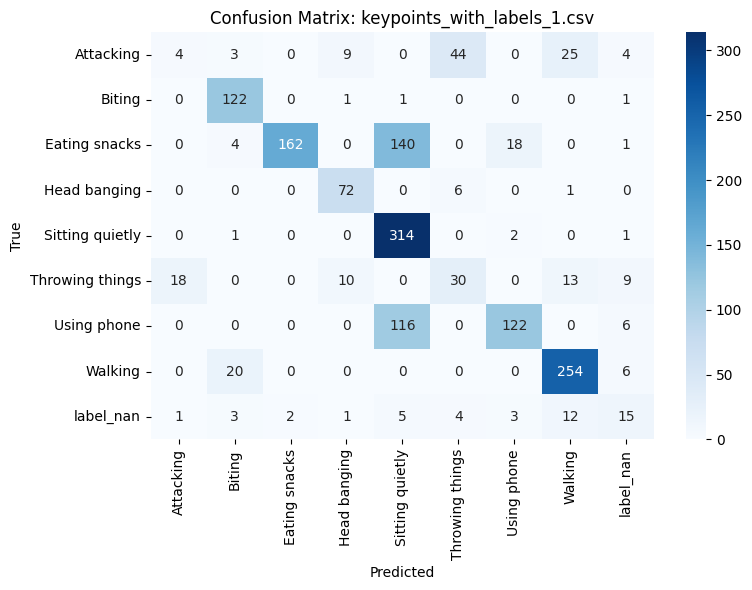

In [10]:
test_seq, test_lbl, test_name = subjects_data[0]

# Combine training data from other subjects
train_seq = np.concatenate([s for j, (s, _, _) in enumerate(subjects_data) if j != 0])
train_lbl = np.concatenate([l for j, (_, l, _) in enumerate(subjects_data) if j != 0])

# Stratified Train/Validation Split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(splitter.split(train_seq, train_lbl))
X_train, y_train = train_seq[train_idx], train_lbl[train_idx]
X_val, y_val = train_seq[val_idx], train_lbl[val_idx]

train_loader = DataLoader(KeypointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(KeypointDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(KeypointDataset(test_seq, test_lbl), batch_size=BATCH_SIZE)

model = GCN_LSTM_Model().to(device)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1e-5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}: Train Loss={total_loss/len(train_loader):.4f}, Train Acc={train_acc:.4f}")

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == batch_y).sum().item()
            val_total += batch_y.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    print(f" Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered based on val_loss.")
            break

# Load best model
model.load_state_dict(best_model_state)

# # Final Test Evaluation
print('------------------TESTING ON SUBJECT 1-----------------')
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(batch_y.numpy())

f1 = f1_score(all_true, all_preds, average='macro')
acc = accuracy_score(all_true, all_preds)
print(f"Test Accuracy = {acc:.4f}, Test Macro F1 = {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.title(f'Confusion Matrix: {test_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import classification_report
# Classification report
report = classification_report(all_true, all_preds, target_names=LABELS)
print(report)

                 precision    recall  f1-score   support

      Attacking       0.17      0.04      0.07        89
         Biting       0.80      0.98      0.88       125
  Eating snacks       0.99      0.50      0.66       325
   Head banging       0.77      0.91      0.84        79
Sitting quietly       0.55      0.99      0.70       318
Throwing things       0.36      0.38      0.37        80
    Using phone       0.84      0.50      0.63       244
        Walking       0.83      0.91      0.87       280
      label_nan       0.35      0.33      0.34        46

       accuracy                           0.69      1586
      macro avg       0.63      0.61      0.59      1586
   weighted avg       0.73      0.69      0.67      1586



In [12]:
# test data loading
test_df = pd.read_csv(r'D:\pr_env\py_env\Scripts\keypoint_test_data\test data_keypoint.csv')
# test_df

In [13]:
extracted_test_features = extract_features(test_df)
# extracted_test_features

In [14]:
final_test_df = pd.concat([test_df, extracted_test_features], axis=1)
final_test_df

,frame_id,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,dist_left_wrist_nose,dist_nose_right_wrist,dist_right_ankle_right_hip,dist_right_ear_right_shoulder,dist_right_elbow_right_knee,dist_right_eye_right_wrist,dist_right_hip_right_wrist,dist_right_knee_right_wrist,dist_right_shoulder_right_wrist,dist_right_ankle_right_wrist
0,0,630.5,420.500,638.5,413.000,621.5,413.500,649.5,419.250,610.0,...,167.757265,173.525935,66.003788,49.412170,61.532512,180.599695,39.852854,60.518592,131.585761,29.970819
1,1,629.5,421.750,637.5,414.000,620.5,414.500,648.5,420.250,609.0,...,167.075021,172.761577,65.946948,48.304374,59.960404,180.136060,39.852854,60.508264,131.230951,30.186918
2,2,629.0,423.250,637.0,415.500,620.0,416.000,648.0,421.000,608.0,...,166.082999,170.756588,66.772000,48.146262,59.052942,178.157936,40.115458,60.508264,129.914635,30.647186
3,3,628.5,424.250,636.5,416.500,619.5,417.250,647.0,421.500,607.0,...,165.028217,169.752945,66.921596,47.754581,58.365229,176.930954,41.039615,60.500000,129.566826,29.769951
4,4,628.5,425.750,636.0,417.750,619.0,418.750,646.0,422.500,606.5,...,164.036010,168.250743,66.610810,46.650295,57.473907,175.480946,41.503012,61.008196,128.981588,28.151377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117916,117916,571.5,215.750,580.5,205.625,560.5,207.250,594.0,208.625,546.5,...,213.898340,219.491458,176.364856,72.149259,168.372541,226.755926,28.022313,99.952801,149.521111,176.275530
117917,117917,572.0,215.625,581.5,205.375,561.0,207.000,595.0,209.000,547.0,...,214.712344,221.306949,176.918060,72.026471,167.198236,228.626469,30.595139,98.426686,150.936452,175.211479
117918,117918,573.0,215.000,582.0,205.125,562.0,206.625,596.0,209.250,548.0,...,216.305918,223.376924,177.074313,71.876630,167.198236,230.380426,31.867891,98.245865,152.138917,174.684000
117919,117919,574.0,214.750,583.0,204.875,563.0,206.375,597.0,209.000,549.0,...,218.051743,224.742074,176.336326,72.343041,166.963506,231.621762,33.448655,98.328849,152.816270,174.051896


In [16]:
feature_columns = final_test_df.columns.difference(['frame_id', 'label'])
ss = StandardScaler()
test_scaled = final_test_df.copy()
test_scaled[feature_columns] = ss.fit_transform(final_test_df[feature_columns])   

# order = [0,1,2,43,60,77,94,
#         3,4,38,55,72,89,
#         5,6,47,64,81,98,
#         7,8,36,53,70,87,
#         9,10,45,62,79,96,
#         11,12,41,58,75,92,
#         13,14,50,67,84,101,
#         15,16,37,54,71,88,
#         17,18,46,63,80,97,
#         19,20,42,59,76,93,
#         21,22,51,68,85,102,
#         23,24,39,56,73,90,
#         25,26,48,65,82,99,
#         27,28,40,57,74,91,
#         29,30,49,66,83,100,
#         31,32,35,52,69,86,
#         33,34,44,61,78,95]
order = [0,1,2,43,60,77,
    3,4,38,55,72,
    5,6,47,64,81,
    7,8,36,53,70,
    9,10,45,62,79,
    11,12,41,58,75,
    13,14,50,67,84,
    15,16,37,54,71,
    17,18,46,63,80,
    19,20,42,59,76,
    21,22,51,68,85,
    23,24,39,56,73,
    25,26,48,65,82,
    27,28,40,57,74,
    29,30,49,66,83,
    31,32,35,52,69,
    33,34,44,61,78]
test_scaled_ordered = test_scaled.iloc[:, order]

In [17]:
test_scaled_ordered

,frame_id,nose_x,nose_y,nose_speed,nose_accel,dist_nose_right_wrist,left_eye_x,left_eye_y,left_eye_speed,left_eye_accel,...,left_ankle_x,left_ankle_y,left_ankle_speed,left_ankle_accel,dist_left_ankle_left_hip,right_ankle_x,right_ankle_y,right_ankle_speed,right_ankle_accel,dist_right_ankle_right_hip
0,0,-0.248519,0.736692,-0.638342,-0.605528,0.768024,-0.224225,0.747038,-0.637371,-0.621265,...,-0.918333,0.191424,-0.464193,-0.446904,-1.082571,-0.101117,0.323853,-0.453786,-0.472857,-1.159910
1,1,-0.266107,0.746920,0.151244,-0.605528,0.756595,-0.241947,0.755201,0.065370,-0.621265,...,-0.918333,0.179500,-0.297005,-0.446904,-1.089772,-0.092232,0.323853,-0.305773,-0.472857,-1.160955
2,2,-0.274902,0.759194,0.141556,-0.141575,0.726616,-0.250807,0.767444,0.148318,0.008467,...,-0.951069,0.167576,0.064503,0.011685,-1.067043,-0.092232,0.334676,-0.305773,-0.255641,-1.145784
3,3,-0.283696,0.767377,-0.086871,-0.190556,0.711609,-0.259668,0.775607,-0.081805,-0.175977,...,-0.940157,0.179500,-0.227753,0.236720,-1.053765,-0.110002,0.334676,-0.157759,-0.129409,-1.143034
4,4,-0.283696,0.779652,0.101534,-0.018668,0.689147,-0.268529,0.785810,0.031619,-0.398621,...,-0.951069,0.179500,-0.297005,-0.105092,-1.035733,-0.145542,0.356323,0.208151,-0.038425,-1.148748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117916,117916,-1.286243,-0.938745,-0.141253,-0.190556,1.455320,-1.252065,-0.945640,-0.136591,-0.162273,...,-0.001732,0.477596,0.008687,-0.014542,1.172591,-1.025147,0.129030,-0.305773,-0.255641,0.869413
117917,117917,-1.277448,-0.939767,-0.384126,-0.190556,1.482466,-1.234344,-0.947681,-0.125165,-0.509943,...,0.009180,0.477596,-0.297005,-0.105092,1.183436,-1.025147,0.129030,-0.453786,-0.319262,0.879585
117918,117918,-1.259860,-0.944882,-0.056677,-0.018668,1.513417,-1.225483,-0.949721,-0.359588,-0.175977,...,0.031004,0.501443,0.008687,-0.105092,1.197139,-1.025147,0.139853,-0.305773,-0.319262,0.882459
117919,117919,-1.242271,-0.946927,-0.129911,-0.294299,1.533830,-1.207762,-0.951762,-0.125165,-0.175977,...,0.063740,0.501443,0.037372,-0.105092,1.195958,-1.025147,0.129030,-0.305773,-0.165667,0.868888


In [18]:
# convert to  sequences
def prepare_test_sequences(df):
    keypoint_df = df.drop(columns=['frame_id'])
    kp_data = keypoint_df.values
    sequences = []
    for i in range(0, len(df) - SEQ_LEN + 1, STEP_SIZE):
        seq = kp_data[i:i+SEQ_LEN]
        seq = seq.reshape((SEQ_LEN, NUM_KEYPOINTS, INPUT_DIM))
        sequences.append(seq)

    return np.array(sequences)


In [19]:
test_sequences = prepare_test_sequences(test_scaled_ordered)

In [20]:
test_sequences.shape

(2619, 90, 17, 5)

In [21]:
# Dataset class
class TestDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        # self.labels = labels 

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32)#, torch.tensor(self.labels[idx], dtype=torch.long)


In [22]:
test_loader = DataLoader(TestDataset(test_sequences), batch_size=BATCH_SIZE, shuffle = False)

In [23]:
import torch.nn.functional as F
from collections import defaultdict
from tqdm import tqdm

total_frames = len(test_df)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
model.eval()

frame_probs = defaultdict(list)
frame_preds = defaultdict(list)

for batch_idx, batch in enumerate(tqdm(test_loader, desc="Predicting")):
    batch = batch.to(device)

    with torch.no_grad():
        outputs = model(batch)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

    for i in range(len(batch)):
        seq_idx = batch_idx * BATCH_SIZE + i
        start_frame = seq_idx * STEP_SIZE
        end_frame = start_frame + SEQ_LEN

        for f in range(start_frame, end_frame):
            if f >= total_frames:
                continue
            frame_probs[f].append(probs[i])
            frame_preds[f].append(preds[i])


Predicting: 100%|██████████| 164/164 [00:20<00:00,  7.87it/s]


In [24]:
inv_label_map = {v: k for k, v in label_map.items()}

final_results = []
for frame in sorted(frame_probs.keys()):
    avg_prob = np.mean(frame_probs[frame], axis=0)
    pred_label = int(np.argmax(avg_prob))
    pred_prob = float(np.max(avg_prob))

    final_results.append({
        "frame_id": frame,
        "predicted_label": pred_label,
        "predicted_class_name": inv_label_map[pred_label],
        "predicted_probability": pred_prob
    })


In [25]:
df = pd.DataFrame(final_results)

In [26]:
df

,frame_id,predicted_label,predicted_class_name,predicted_probability
0,0,4,Sitting quietly,0.980090
1,1,4,Sitting quietly,0.980090
2,2,4,Sitting quietly,0.980090
3,3,4,Sitting quietly,0.980090
4,4,4,Sitting quietly,0.980090
...,...,...,...,...
117895,117895,8,label_nan,0.977274
117896,117896,8,label_nan,0.977274
117897,117897,8,label_nan,0.977274
117898,117898,8,label_nan,0.977274


In [ ]:
df.to_csv("frame_level_predictions_69acc_59f1.csv", index=False)

In [ ]:
# output_csv = pd.read_csv(r'D:\pr_env\py_env\Scripts\test data_keypoint_copy.csv')

In [ ]:
# output_csv['predicted_label'] = df['predicted_class_name']

In [ ]:
# output_csv.to_csv('jmi_mca_test.csv', index=False)